In [145]:
from datetime import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pylab import rcParams

# set maximum display rows as 200
pd.set_option('display.max_rows', 200)

plt.style.use('ggplot') # use ggplot styling
# displays graphs in the notebook
%matplotlib inline

In [2]:
df =pd.read_sql_table('coffee_machine', 'sqlite:///dissertation.db') 

In [3]:
df_copy = df.copy()

In [4]:
df_copy

,time,mean_power,weekofyear,day_name,hour,mins,day_type,kWh
0,2019-12-23 00:00:00,0.0,-1,0,0,0,weekday,0.0
1,2019-12-23 00:00:10,0.0,-1,0,0,0,weekday,0.0
2,2019-12-23 00:00:20,0.0,-1,0,0,0,weekday,0.0
3,2019-12-23 00:00:30,0.0,-1,0,0,0,weekday,0.0
4,2019-12-23 00:00:40,0.0,-1,0,0,0,weekday,0.0
...,...,...,...,...,...,...,...,...
1451515,2020-06-07 23:59:10,0.0,23,6,23,59,holiday,0.0
1451516,2020-06-07 23:59:20,0.0,23,6,23,59,holiday,0.0
1451517,2020-06-07 23:59:30,0.0,23,6,23,59,holiday,0.0
1451518,2020-06-07 23:59:40,0.0,23,6,23,59,holiday,0.0


In [629]:
# group by half an hour
df_half = pd.DataFrame ({'Actual':(df_copy.groupby(pd.Grouper(freq='30T',key='time'))['kWh'].sum().ffill()*1000)})

In [630]:
df_half.describe()

,Actual
count,8064.000000
mean,14.843988
std,44.994685
min,0.000000
25%,0.000000
50%,0.000000
75%,0.001389
max,384.235833


https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [631]:
# subset 80% of dataset for train and test, 20% for prediction
subset_num = 6451
df_train_test = df_half[['Actual']][:subset_num]
df_simul = df_half[['Actual']][subset_num:]

# transform 
#train_test=df_train_test.values
#train_test=train_test.astype('float32')

#simu=df_simu.values
#simu=simu.astype('float32')

In [632]:
size=1
df_train= df_train_test [:int(subset_num*size)]
df_test= df_train_test [int(subset_num*size):]
print(len(df_train),len(df_test))

6451 0


In [633]:
# test stationary
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df_train.Actual, regression ='ctt')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -11.888481
p-value: 0.000000
Critial Values:
   1%, -4.372937294115271
Critial Values:
   5%, -3.83331091190546
Critial Values:
   10%, -3.5538306043089496


In [634]:
# test stationary
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df_test.Actual, regression ='ctt')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ValueError: sample size is too short to use selected regression component

In [583]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

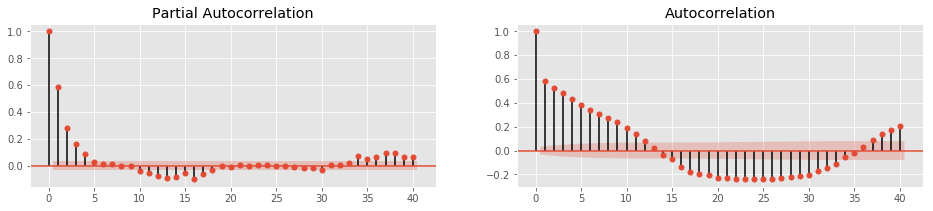

In [307]:
# one pacf and acf
fig, axes = plt.subplots(1, 2, sharex=True,figsize=(16,3))

plot_pacf(df_train.Actual, lags=40, ax=axes[0])
plot_acf(df_train.Actual,lags=40, ax=axes[ 1])

plt.show()

In [635]:
# arima (2,1,1)
from statsmodels.tsa.arima_model import ARIMA

model1 = ARIMA(df_train, order=(3,0,3))
model_fit1 = model1.fit(disp=0)
print(model_fit1.summary())

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\base\mode

                              ARMA Model Results                              
Dep. Variable:                 Actual   No. Observations:                 6451
Model:                     ARMA(3, 3)   Log Likelihood              -32173.613
Method:                       css-mle   S.D. of innovations                nan
Date:                Thu, 20 Aug 2020   AIC                          64363.226
Time:                        20:18:47   BIC                          64417.402
Sample:                    12-23-2019   HQIC                         64381.971
                         - 05-05-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           18.4907        nan        nan        nan         nan         nan
ar.L1.Actual     2.8960      0.000   2.67e+04      0.000       2.896       2.896
ar.L2.Actual    -2.8106      0.000  -2.67e+0

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


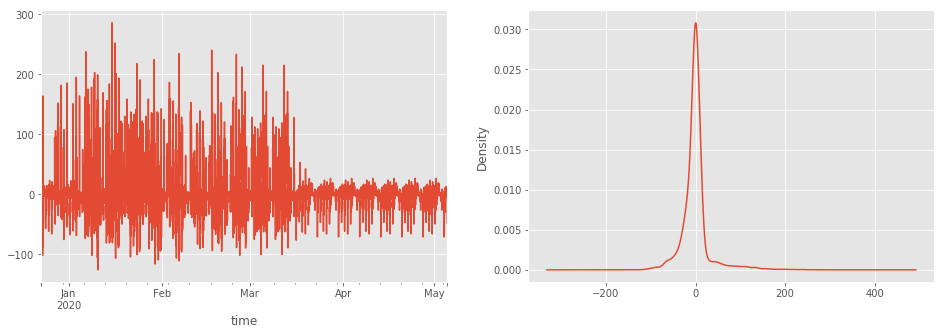

In [636]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
model_fit0.resid.plot(ax=axes[0])
model_fit0.resid.plot(kind='kde', ax=axes[1])# using one difference

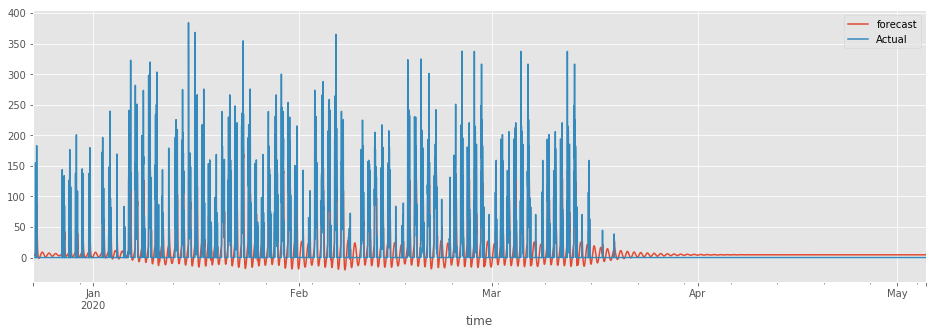

In [650]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 5
model_fit1.plot_predict(dynamic=False)
plt.show()

In [310]:
# predict the model
predict_train= model_fit0.predict(dynamic=False)
predict_test = model_fit0.predict(df_test.index[0],df_test.index[-1],dynamic=True)
#predict_simul = model_fit0.predict(df_s.index[0],df_simul.index[1],dynamic=True)

In [275]:
df_half_diff=df_half.diff()

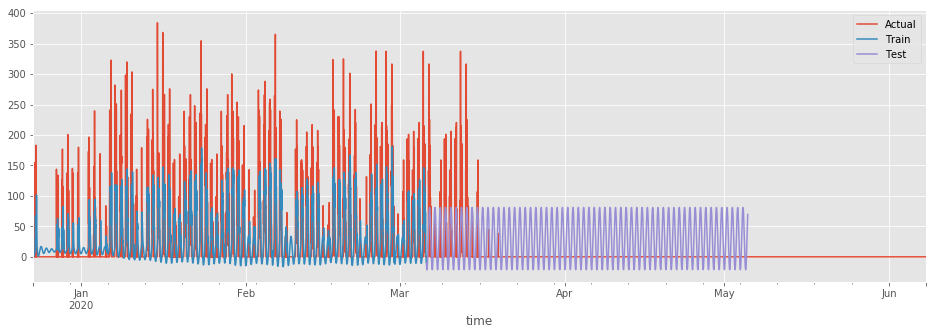

In [311]:
time_index = pd.date_range(start='12/23/2019 00:00:00', end='6/07/2020 23:30:00', freq='30T')
df_model_train= pd.DataFrame(predict_train, columns=({'Train'})).set_index(time_index[3:int(subset_num*size+3)])
df_model_test= pd.DataFrame(predict_test, columns=({'Test'})).set_index(time_index[3+int(subset_num*size):6451+3])
#df_model_simu= pd.DataFrame(predict_simul, columns=({'Prediction'})).set_index(time_index[6451:])

df_all=pd.concat([df_half, df_model_train,df_model_test], axis=1)
#df_sub_pred = df_predict.merge(df_predict,left_on='time',right_on='time')



# plot the result
df_all.set_index(df_all.index).plot(figsize=(16,5))
#plt.ylabel('Wh')

In [312]:
# next hour prediction
next_halfhour=model_fit0.forecast(steps=1, exog=None, alpha=0.05)

print('Pred: ',next_halfhour[0],'Std: ',next_halfhour[1],'Confidence: ', next_halfhour[2])
print('Actual: ',df_half_diff['Actual'][6451:6452])

Pred:  [-10.7261477] Std:  [44.68537681] Confidence:  [[-98.30787689  76.85558149]]
Actual:  time
2020-05-05 09:30:00    0.001389
Freq: 30T, Name: Actual, dtype: float64


In [313]:
mae = np.mean(np.abs(df_all['Test'][int(subset_num*size):6451] - df_all['Actual'][int(subset_num*size):6451]))
rmse = np.mean((df_all['Test'][int(subset_num*size):6451] - df_all['Actual'][int(subset_num*size):6451])**2)**.5

print('MAE: ', mae, 'RMSE: ',rmse)

MAE:  37.7688099777364 RMSE:  47.47956004739413


## Decompose Seasonal

In [555]:
from statsmodels.tsa.seasonal import seasonal_decompose
# decompose seasonal 
decom = seasonal_decompose(df_half['Actual'], model='addicative', extrapolate_trend='freq', freq=336)
#decom1 = seasonal_decompose(df_half['Actual'], model='addicative', extrapolate_trend='freq', freq=48)
deseason = df_half.Actual.values - decom.seasonal 
deseason = pd.DataFrame(deseason)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [556]:
deseason.rename(columns=({'seasonal':'Actual'}),inplace=True)
deseason

,Actual
time,
2019-12-23 00:00:00,14.908956
2019-12-23 00:30:00,14.909699
2019-12-23 01:00:00,14.910557
2019-12-23 01:30:00,14.911009
2019-12-23 02:00:00,14.912041
...,...
2020-06-07 21:30:00,14.797624
2020-06-07 22:00:00,14.798029
2020-06-07 22:30:00,14.797798


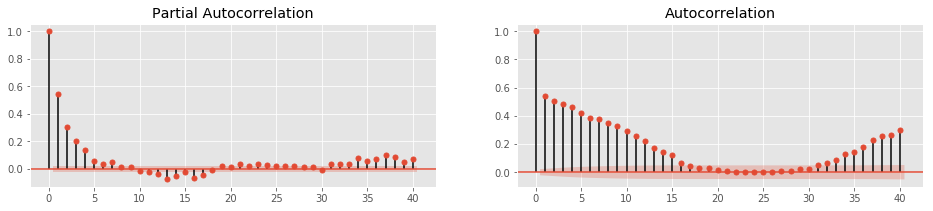

In [557]:
# one pacf and acf
fig, axes = plt.subplots(1, 2, sharex=True,figsize=(16,3))

plot_pacf(deseason.Actual, lags=40, ax=axes[0])
plot_acf(deseason.Actual,lags=40, ax=axes[ 1])

plt.show()

In [558]:
# test stationary
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(deseason.Actual, regression ='ctt')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -9.895477
p-value: 0.000000
Critial Values:
   1%, -4.372574209231234
Critial Values:
   5%, -3.833125923487515
Critial Values:
   10%, -3.553715993569947


In [559]:
# subset 80% of dataset for train and test, 20% for prediction
subset_num = 6451
df_train_test = deseason[['Actual']][:subset_num]
df_simul = deseason[['Actual']][subset_num:]

# transform 
#train_test=df_train_test.values
#train_test=train_test.astype('float32')

#simu=df_simu.values
#simu=simu.astype('float32')

In [617]:
size=1
df_train= df_train_test [:int(subset_num*size)]
df_test= df_train_test [int(subset_num*size):]
print(len(df_train),len(df_test))

6451 0


In [618]:
#train 
model0 = ARIMA(df_train, order=(3,0,3))
model_fit0 = model0.fit(disp=0)
print(model_fit0.summary())

                              ARMA Model Results                              
Dep. Variable:                 Actual   No. Observations:                 6451
Model:                     ARMA(3, 3)   Log Likelihood              -31486.283
Method:                       css-mle   S.D. of innovations             31.870
Date:                Thu, 20 Aug 2020   AIC                          62988.566
Time:                        20:11:47   BIC                          63042.742
Sample:                    12-23-2019   HQIC                         63007.311
                         - 05-05-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           18.1362      4.769      3.803      0.000       8.789      27.484
ar.L1.Actual     2.9675      0.001   5817.735      0.000       2.966       2.968
ar.L2.Actual    -2.9514      0.001  -3412.02

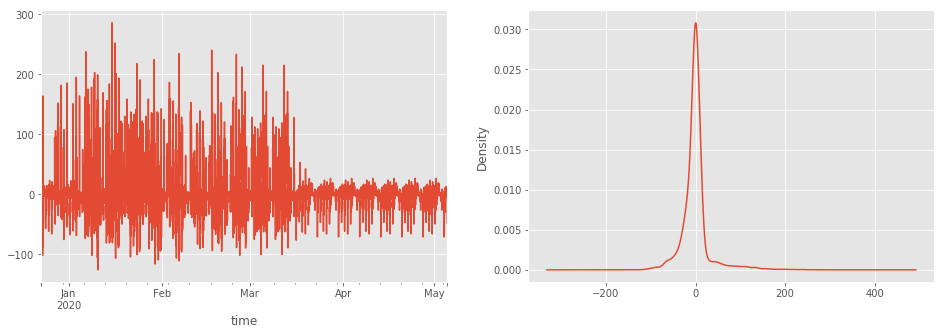

In [619]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
model_fit0.resid.plot(ax=axes[0])
model_fit0.resid.plot(kind='kde', ax=axes[1])# using one difference

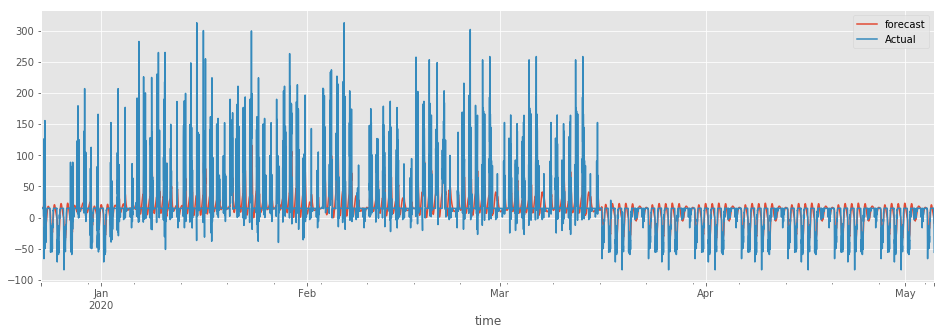

In [651]:
rcParams['figure.figsize'] = 16, 5
model_fit0.plot_predict(dynamic=False)
plt.show()

In [574]:
# predict the model
predict_train= model_fit0.predict(dynamic=False)
#predict_test = model_fit0.predict(df_test.index[0],df_test.index[-1],dynamic=True)
#predict_simul = model_fit0.predict(df_s.index[0],df_simul.index[1],dynamic=True)

In [620]:
df_train.rename(columns={'Actual':'Train'},inplace=True)
df_train

,Train
time,
2019-12-23 00:00:00,14.908956
2019-12-23 00:30:00,14.909699
2019-12-23 01:00:00,14.910557
2019-12-23 01:30:00,14.911009
2019-12-23 02:00:00,14.912041
...,...
2020-05-05 07:00:00,14.884479
2020-05-05 07:30:00,6.813844
2020-05-05 08:00:00,-7.283174


Text(0, 0.5, 'Wh')

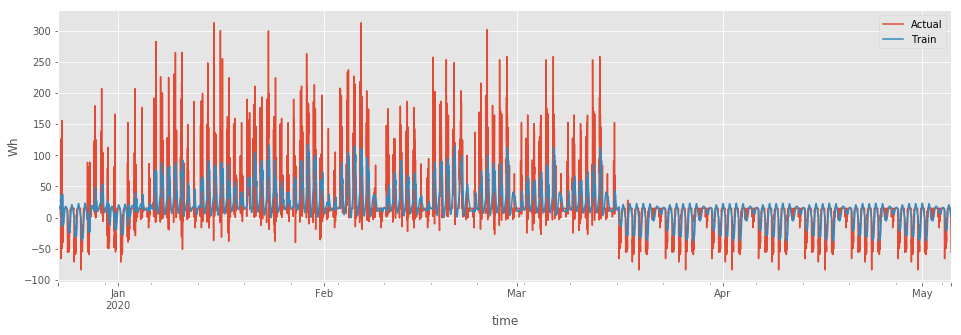

In [654]:
time_index = pd.date_range(start='12/23/2019 00:00:00', end='6/07/2020 23:30:00', freq='30T')
df_model_train= pd.DataFrame(predict_train, columns=({'Train'})).set_index(time_index[3:int(subset_num*size+3)])
#df_model_test= pd.DataFrame(predict_test, columns=({'Test'})).set_index(time_index[3+int(subset_num*size):6451+3])
#df_model_simu= pd.DataFrame(predict_simul, columns=({'Prediction'})).set_index(time_index[6451:])

df_all=pd.concat([deseason, df_model_train], axis=1)
#df_sub_pred = df_predict.merge(df_predict,left_on='time',right_on='time')



# plot the result
df_all[:6451].set_index(df_all[:6451].index).plot(figsize=(16,5))
plt.ylabel('Wh')

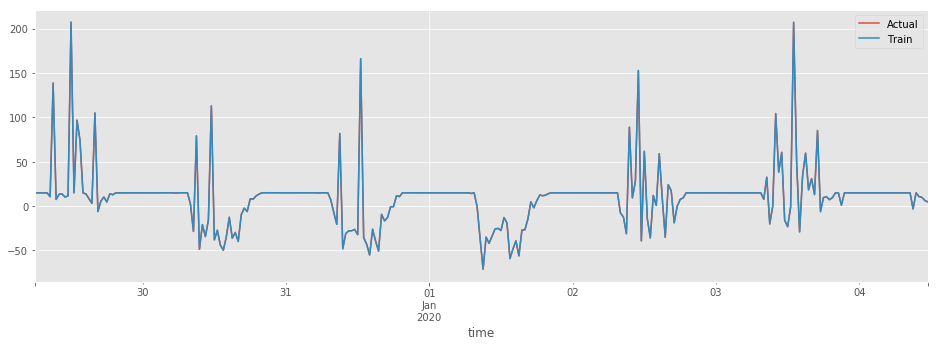

In [622]:
df_all[300:600].set_index(df_all[300:600].index).plot(figsize=(16,5))
#plt.ylabel('Wh')

In [611]:
# next hour prediction
next_halfhour=model_fit0.forecast(steps=1, exog=None, alpha=0.05)

print('Pred: ',next_halfhour[0],'Std: ',next_halfhour[1],'Confidence: ', next_halfhour[2])
print('Actual: ',deseason['Actual'][6451:6452])

Pred:  [-17.61482817] Std:  [31.86987029] Confidence:  [[-80.07862613  44.84896978]]
Actual:  time
2020-05-05 09:30:00   -48.219367
Freq: 30T, Name: Actual, dtype: float64


In [585]:
predict_next = model_fit0.predict(deseason.index[3],deseason.index[-1],dynamic=True)
next_halfhour = predict_next[6448:6449]
next_halfhour

2020-05-05 09:30:00    18.136203
Freq: 30T, dtype: float64

In [579]:
df_half[6451:6452]

,Actual
time,
2020-05-05 09:30:00,0.002778


In [580]:
df_all

,Actual,Train
time,,
2019-12-23 00:00:00,14.908956,NaN
2019-12-23 00:30:00,14.909699,NaN
2019-12-23 01:00:00,14.910557,NaN
2019-12-23 01:30:00,14.911009,18.136203
2019-12-23 02:00:00,14.912041,16.595037
...,...,...
2020-06-07 21:30:00,14.797624,NaN
2020-06-07 22:00:00,14.798029,NaN
2020-06-07 22:30:00,14.797798,NaN


In [582]:
mae = np.mean(np.abs(df_all['Actual'][:6451] - df_all['Train'][:6451]))
rmse = np.mean((df_all['Actual'][:6451] - df_all['Train'][:6451])**2)**.5

print('MAE: ', mae, 'RMSE: ',rmse)

MAE:  19.284868882319316 RMSE:  33.83524916708546


In [607]:
# with lockdown
mad_mean_ratio =19.28*6451/df_all['Actual'][:6451].sum() 
mad_mean_ratio

1.0392620341624268

In [606]:
(abs((df_all['Actual'][:6451] - df_all['Train'][:6451])/df_all['Actual'][:6451])).sum()/6451

3.3605192649095588

In [432]:
df_predict_train=pd.DataFrame(predict_next[:int(subset_num*size)-3], columns=({'Train'})).set_index(time_index[3:int(subset_num*size)])
df_predict_test=pd.DataFrame(predict_next[int(subset_num*size)-3:], columns=({'Train'})).set_index(time_index[3:int(subset_num*size)])

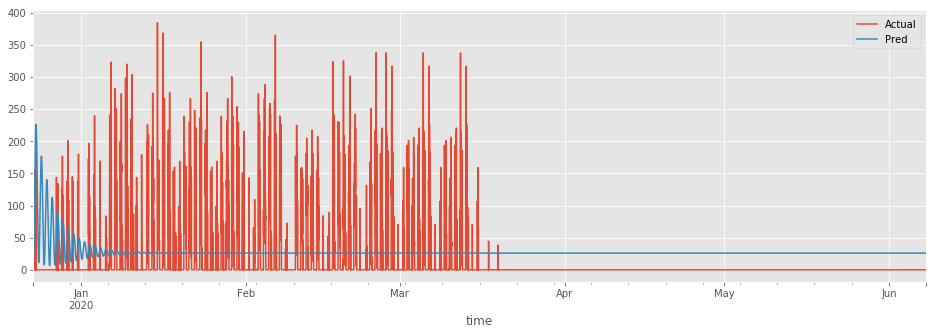

In [434]:
df_predict_next = pd.DataFrame(predict_next, columns=({'Pred'}))
df_all=pd.concat([df_half, df_predict_next], axis=1)
df_all.set_index(df_all.index).plot(figsize=(16,5))

In [436]:
df_all

,Actual,Pred
time,,
2019-12-23 00:00:00,0.0,NaN
2019-12-23 00:30:00,0.0,NaN
2019-12-23 01:00:00,0.0,NaN
2019-12-23 01:30:00,0.0,20.263639
2019-12-23 02:00:00,0.0,23.137773
...,...,...
2020-06-07 21:30:00,0.0,26.030830
2020-06-07 22:00:00,0.0,26.030830
2020-06-07 22:30:00,0.0,26.030830
